In [1]:
import os
os.chdir('..')
# print(os.getcwd()

In [2]:
import pandas as pd
import CustFun
from sklearn.metrics import mean_pinball_loss,mean_absolute_error,r2_score
import numpy as np 

In [3]:
df = pd.read_csv('./feature_engineering/worldGame_add_group1202.csv',index_col=0)

nor_cols = [ 'old', 'bwt', 'sq', 'bp', 'dl', 'total', 'ipf_gl_c','year']
cat_cols = [ 'group','team', 'wc','gender','rank']

df = df[nor_cols+cat_cols]
for f in cat_cols:
    df[f] = df[f].astype('category')

### 透過sq(深蹲)和Rank(名次)重量來預測bp(臥推)+dl(硬舉)的試舉重量
### 適用情境：打破深蹲紀錄

<h>說明：根據規則破紀錄其它項目也必須要有成績才會被承認，此使用情境可幫助有意破紀錄的選手，提供其他項目試舉重量建議</h>

In [4]:
df['bp_dl'] = df['bp'] + df['dl']
nor_cols.append('bp_dl')

### 設定特徵用的欄位

In [5]:
x_cols = cat_cols+['old', 'bwt', 'sq', 'ipf_gl_c','year']
y_col = 'bp_dl'

In [6]:
print(x_cols)

['group', 'team', 'wc', 'gender', 'rank', 'old', 'bwt', 'sq', 'ipf_gl_c', 'year']


### 設定訓練模型要探索的超參數

In [7]:
dic_train_hyperparams = {'lgbm':{},'xgb':{},'lgbm_q05':{},'lgbm_q95':{}}

In [8]:
dic_train_hyperparams['lgbm']['static'] = {
    'n_estimators':1000,
    'early_stopping_rounds':100,
    'verbose':-2,
    'n_jobs':4,
    'metric':'mape'
}

dic_train_hyperparams['lgbm']['optimize'] = {
    'learning_rate':'float,0.001,0.04',
    'max_leaves':'int,1,32',
    'max_depth':'int,1,18',
    'min_data_in_leaf':'int,4,16',
    'feature_fraction':'float,0.01,1',
    'bagging_fraction':'float,0.01,1',
    'bagging_freq':'int,1,5',
    'reg_alpha': 'float,0.01,15',
    'reg_lambda': 'float,0.01,4',
    'random_state':'int,0,1000',
    'min_split_gain':'float,0.01,1',
    # 'metric':'str,mse,mae,rmse,mape'
    }

dic_train_hyperparams['xgb']['static'] = {
    'n_estimators':1000,
    'verbosity':0,
    'n_jobs':4,
    'enable_categorical':True,
    'metric':'mape'
}

dic_train_hyperparams['xgb']['optimize'] = {
    'learning_rate':'float,0.001,0.04',
    'max_leaves':'int,1,32',
    'max_depth':'int,1,18',
    'gamma':'float,0.01,1.5',
    'reg_alpha': 'float,0.01,12',
    'reg_lambda': 'float,0.01,1.75',
    'random_state':'int,0,1000',
    'min_split_gain':'float,0.01,1',
    # 'metric':'str,mse,mae,rmse,mape'
    }

dic_train_hyperparams['lgbm_q05']['static'] = {
    'objective':'quantile',
    'alpha':0.05,
    'n_estimators':1000,
    'early_stopping_rounds':100,
    'verbose':-1,
    'n_jobs':4,
}

dic_train_hyperparams['lgbm_q05']['optimize'] = {
    'learning_rate':'float,0.001,0.04',
    'max_leaves':'int,1,32',
    'max_depth':'int,1,18',
    'min_data_in_leaf':'int,4,16',
    'feature_fraction':'float,0.01,1',
    'bagging_fraction':'float,0.01,1',
    'bagging_freq':'int,1,5',
    'reg_alpha': 'float,0.01,15',
    'reg_lambda': 'float,0.01,4',
    'min_split_gain':'float,0.01,1',
    'random_state':'int,0,1000',
}

dic_train_hyperparams['lgbm_q95']['static'] = {
    'objective':'quantile',
    'alpha':0.95,
    'n_estimators':1000,
    'early_stopping_rounds':100,
    'verbose':-1,
    'n_jobs':4,
}

dic_train_hyperparams['lgbm_q95']['optimize'] = {
    'learning_rate':'float,0.001,0.04',
    'max_leaves':'int,1,32',
    'max_depth':'int,1,18',
    'min_data_in_leaf':'int,4,16',
    'feature_fraction':'float,0.01,1',
    'bagging_fraction':'float,0.01,1',
    'bagging_freq':'int,1,5',
    'reg_alpha': 'float,0.01,15',
    'reg_lambda': 'float,0.01,4',
    'min_split_gain':'float,0.01,1',
    'random_state':'int,0,1000',
}

In [9]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df,test_size=0.2, random_state=42)

### 預測BP(臥推)+DL(硬舉):LGBM、XGBoost

In [ ]:
CustFun.LBGMRegTrain(train,x_cols,y_col,
                    dic_train_hyperparams['lgbm']['optimize'],
                    dic_train_hyperparams['lgbm']['static'],
                    100,optimize_n_job=2,
                    study_path1='./predict_bp_dl/optuna/lgbm_bp_dl_1.pkl',
                    study_path2='./predict_bp_dl/optuna/lgbm_bp_dl_2.pkl',
                    metric='mape',
                    is_maximize=False,
                    categorical_feature = [0,1,2,3,4])

CustFun.XGBRegTrain(train,x_cols,y_col,
                    dic_train_hyperparams['xgb']['optimize'],
                    dic_train_hyperparams['xgb']['static'],
                    100,optimize_n_job=2,
                    study_path1='./predict_bp_dl/optuna/xgb_bp_dl_1.pkl',
                    study_path2='./predict_bp_dl/optuna/xgb_bp_dl_2.pkl',
                    metric='mape',
                    is_maximize=False,
                    )

### 使用LGBM預測 90% 預測區間

In [ ]:
CustFun.LBGMQRegTrain(train,x_cols,y_col,
                    dic_train_hyperparams['lgbm_q05']['optimize'],
                    dic_train_hyperparams['lgbm_q05']['static'],
                    200,optimize_n_job=2,
                    study_path1='./predict_bp_dl/optuna/lgbm_Q05_bp_dl_1.pkl',
                    study_path2='./predict_bp_dl/optuna/lgbm_Q05_bp_dl_2.pkl',
                    categorical_feature = [0,1,2,3,4])

CustFun.LBGMQRegTrain(train,x_cols,y_col,
                    dic_train_hyperparams['lgbm_q95']['optimize'],
                    dic_train_hyperparams['lgbm_q95']['static'],
                    200,optimize_n_job=2,
                    study_path1='./predict_bp_dl/optuna/lgbm_Q95_bp_dl_1.pkl',
                    study_path2='./predict_bp_dl/optuna/lgbm_Q95_bp_dl_2.pkl',
                    categorical_feature = [0,1,2,3,4])

In [12]:
from sklearn.model_selection import KFold

In [13]:
df_tmp = df.sample(len(df),replace=False).copy()

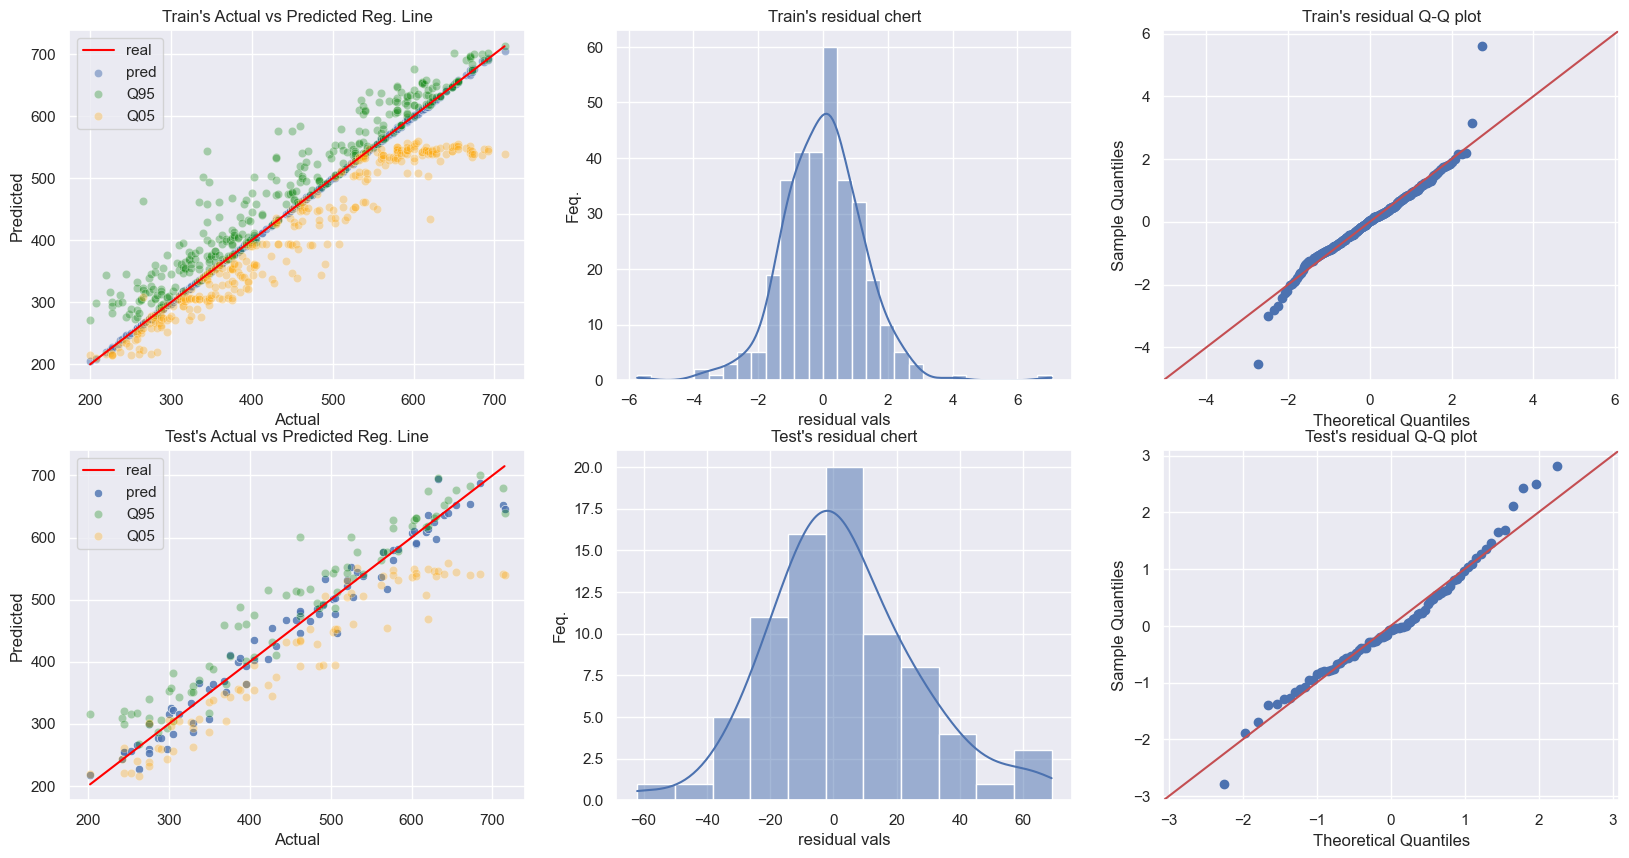

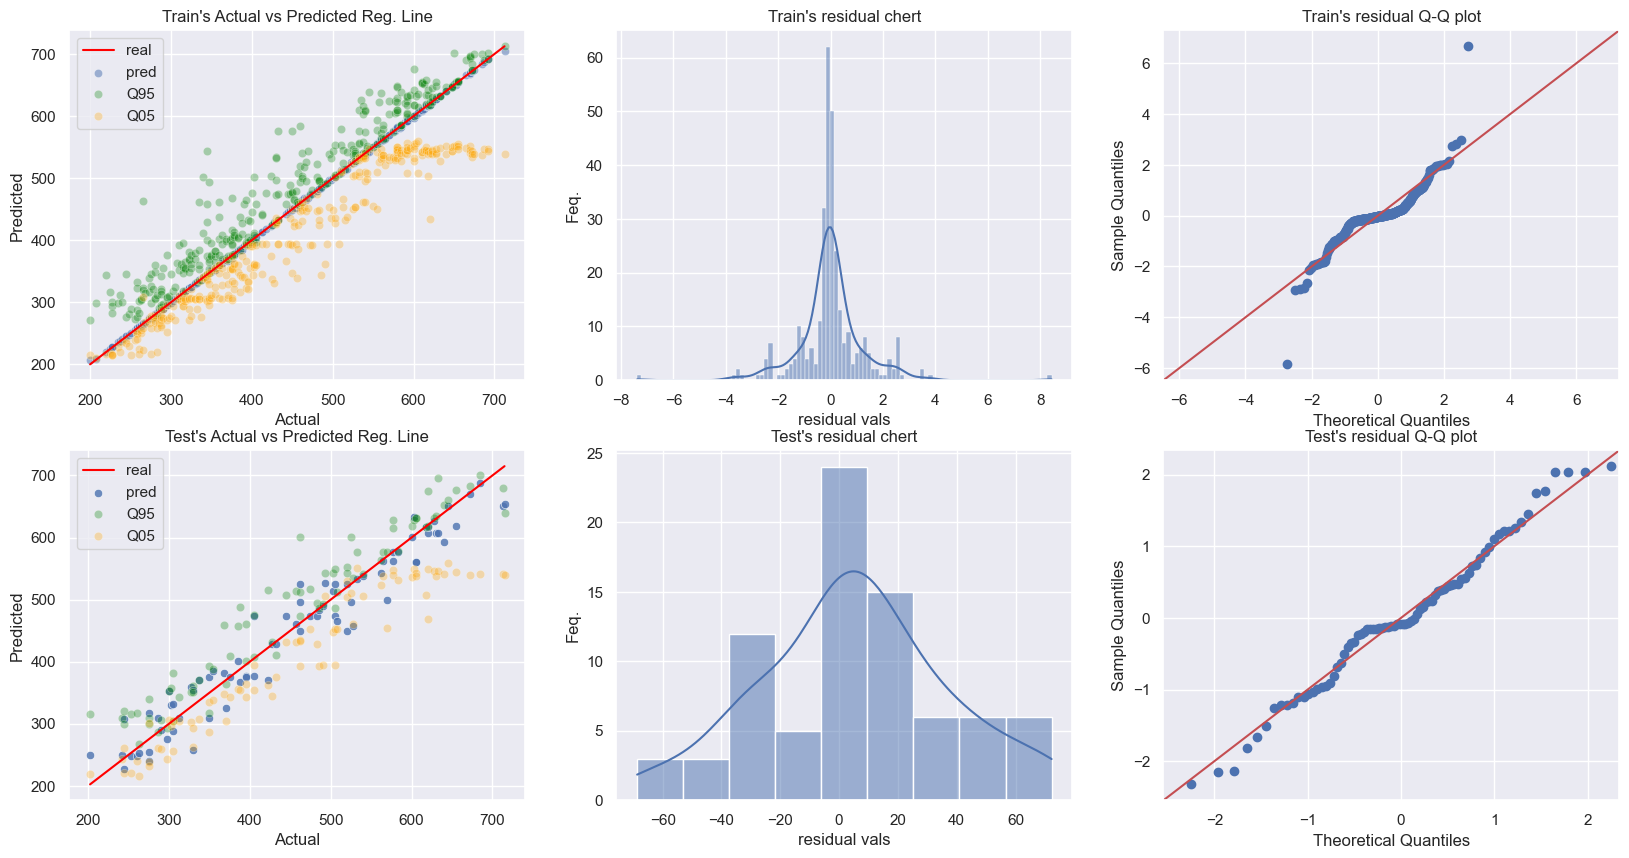

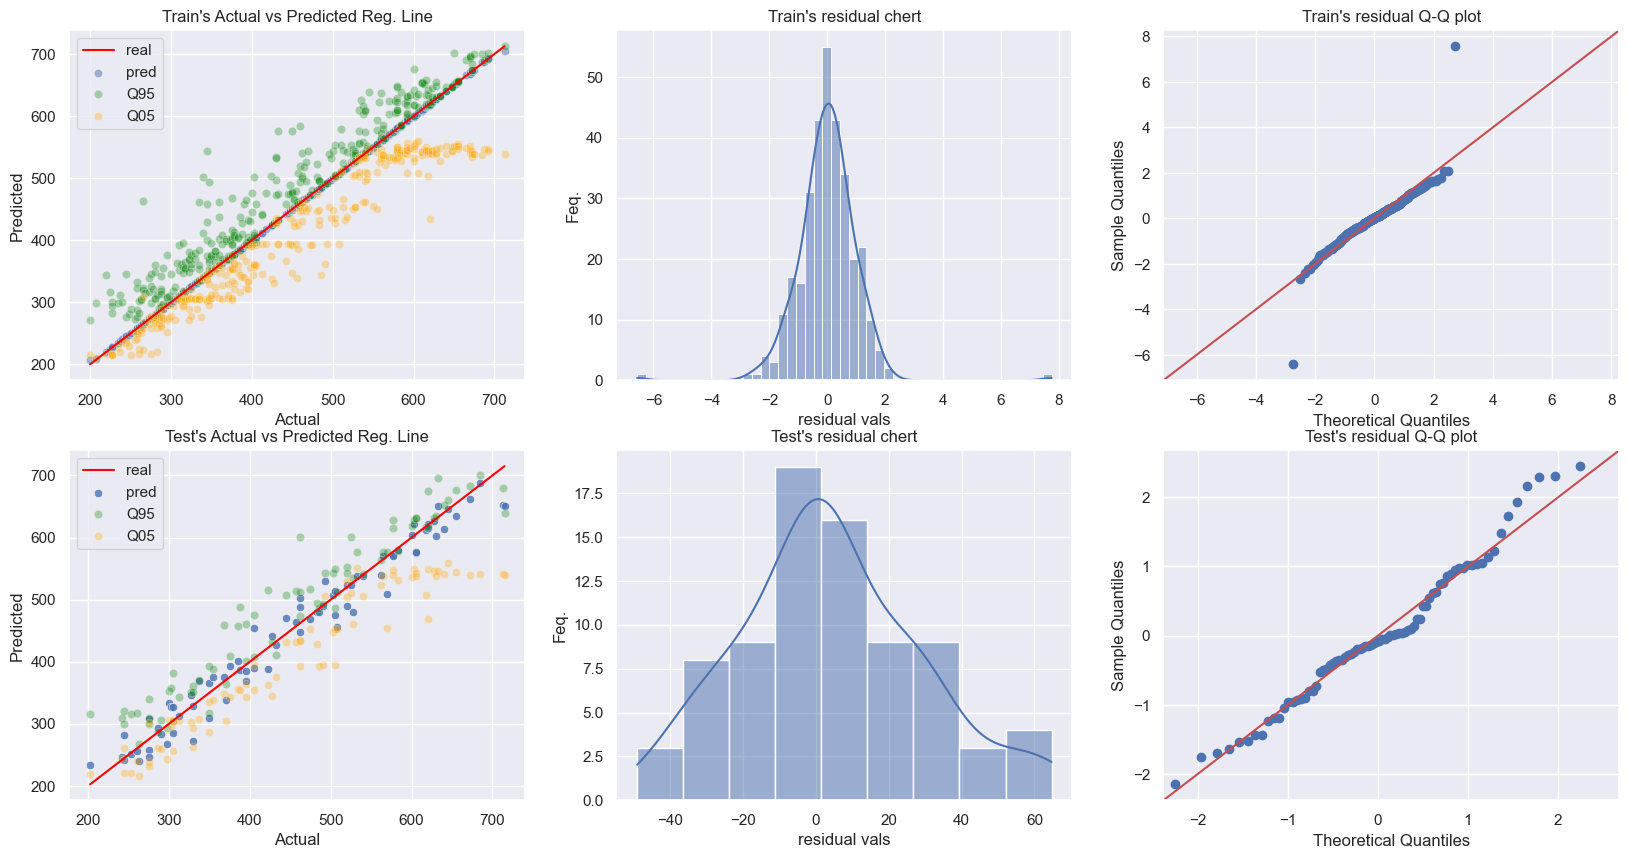

In [14]:
lst_pred_quantile_bp_dl = []
lst_pred_pi_bp_dl = []
lst_pred_bp_dl = []

dic_train_hyperparams['lgbm_q05']['static'].pop('early_stopping_rounds',None)
lower_train_pred,lower_test_pred,q05_score = CustFun.doule_train_pred(train,test,x_cols,y_col,
                                                dic_train_hyperparams['lgbm_q05']['static'],
                                                './predict_bp_dl/optuna/lgbm_Q05_bp_dl_1.pkl','./predict_bp_dl/optuna/lgbm_Q05_bp_dl_2.pkl',
                                                'lgbm_q05',quantile_alpha=0.05)

dic_train_hyperparams['lgbm_q95']['static'].pop('early_stopping_rounds',None)
upper_train_pred,upper_test_pred,q95_score = CustFun.doule_train_pred(train,test,x_cols,y_col,
                                                dic_train_hyperparams['lgbm_q95']['static'],
                                                './predict_bp_dl/optuna/lgbm_Q95_bp_dl_1.pkl','./predict_bp_dl/optuna/lgbm_Q95_bp_dl_2.pkl',
                                                'lgbm_q95',quantile_alpha=0.95)

df_pred_quantile_bp_dl = pd.concat([q95_score,q05_score])
df_pred_quantile_bp_dl = pd.concat([df_pred_quantile_bp_dl.loc[df_pred_quantile_bp_dl.index == 'train'],
                                    df_pred_quantile_bp_dl.loc[df_pred_quantile_bp_dl.index == 'test']],
                                    axis=0)

y_train = train[y_col].to_numpy().ravel()
y_test = test[y_col].to_numpy().ravel()

lower_train_pinball_loss = mean_pinball_loss(y_train, lower_train_pred,alpha=0.05)
upper_train_pinball_loss = mean_pinball_loss(y_train, upper_train_pred,alpha=0.95)

lower_test_pinball_loss = mean_pinball_loss(y_test, lower_test_pred,alpha=0.05)
upper_test_pinball_loss = mean_pinball_loss(y_test, upper_test_pred,alpha=0.95)

df_pi_dp_dl = pd.DataFrame(data={
                "上限誤差":[upper_train_pinball_loss,upper_test_pinball_loss],
                "下限誤差":[lower_train_pinball_loss,lower_test_pinball_loss],
                "1倍誤差測區間":[CustFun.get_quantile_coverage(y_train,upper_train_pred,lower_train_pred,
                                        upper_train_pinball_loss,lower_train_pinball_loss,
                                        upper_k=1,lower_k=1),
                                CustFun.get_quantile_coverage(y_test,upper_test_pred,lower_test_pred,
                                        upper_test_pinball_loss,lower_test_pinball_loss,
                                        upper_k=1,lower_k=1)],
                "3倍誤差預測區間":[CustFun.get_quantile_coverage(y_train,upper_train_pred,lower_train_pred,
                                        upper_train_pinball_loss,lower_train_pinball_loss,
                                        upper_k=3,lower_k=3),
                                CustFun.get_quantile_coverage(y_test,upper_test_pred,lower_test_pred,
                                        upper_test_pinball_loss,lower_test_pinball_loss,
                                        upper_k=3,lower_k=3)],
                "5倍誤差預測區間":[CustFun.get_quantile_coverage(y_train,upper_train_pred,lower_train_pred,
                                        upper_train_pinball_loss,lower_train_pinball_loss,
                                        upper_k=5,lower_k=5),
                                CustFun.get_quantile_coverage(y_test,upper_test_pred,lower_test_pred,
                                        upper_test_pinball_loss,lower_test_pinball_loss,
                                        upper_k=5,lower_k=5)]
                },index=['train','test'])

dic_train_hyperparams['lgbm']['static'].pop('early_stopping_rounds',None)
lgbm_train_pred,lgbm_test_pred,lgbm_score = CustFun.doule_train_pred(train,test,x_cols,y_col,
                                                dic_train_hyperparams['lgbm']['static'],
                                                './predict_bp_dl/optuna/lgbm_bp_dl_1.pkl','./predict_bp_dl/optuna/lgbm_bp_dl_2.pkl',
                                                'lgbm')

xgb_train_pred,xgb_test_pred,xgb_score = CustFun.doule_train_pred(train,test,x_cols,y_col,
                                                dic_train_hyperparams['xgb']['static'],
                                                './predict_bp_dl/optuna/xgb_bp_dl_1.pkl','./predict_bp_dl/optuna/xgb_bp_dl_2.pkl',
                                                'xgb',is_lgbm=False)

merge_train_pred = np.mean([lgbm_train_pred,xgb_train_pred],axis=0)
merge_test_pred = np.mean([lgbm_test_pred,xgb_test_pred],axis=0)

merge_train_mae = mean_absolute_error(y_train, merge_train_pred)
merge_test_mae = mean_absolute_error(y_test, merge_test_pred)

merge_score = pd.DataFrame(data={
                        "model":['merge','merge'],
                        "r2_score":[r2_score(y_train, merge_train_pred),r2_score(y_test, merge_test_pred)],
                        "mae":[merge_train_mae,merge_test_mae],
                        "1倍誤差覆蓋率":[CustFun.get_coverage(y_train,merge_train_pred,merge_train_mae),
                                CustFun.get_coverage(y_test,merge_test_pred,merge_test_mae)],
                        "2倍誤差覆蓋率":[CustFun.get_coverage(y_train,merge_train_pred,merge_train_mae,k=2),
                                CustFun.get_coverage(y_test,merge_test_pred,merge_test_mae,k=2)],
                        "2.5倍誤差覆蓋率":[CustFun.get_coverage(y_train,merge_train_pred,merge_train_mae,k=2.5),
                                CustFun.get_coverage(y_test,merge_test_pred,merge_test_mae,k=2.5)]
                        },index=['train','test'])

CustFun.resultPlot(y_train,lgbm_train_pred,y_test,lgbm_test_pred,lower_train_pred,upper_train_pred,lower_test_pred,upper_test_pred)

CustFun.resultPlot(y_train,xgb_train_pred,y_test,xgb_test_pred,lower_train_pred,upper_train_pred,lower_test_pred,upper_test_pred)

CustFun.resultPlot(y_train,merge_train_pred,y_test,merge_test_pred,lower_train_pred,upper_train_pred,lower_test_pred,upper_test_pred)

df_pred_bp_dl = pd.concat([lgbm_score,xgb_score,merge_score])
df_pred_bp_dl = pd.concat([df_pred_bp_dl.loc[df_pred_bp_dl.index == 'train'],
                           df_pred_bp_dl.loc[df_pred_bp_dl.index == 'test']],
                           axis=0)



In [15]:
df_pred_quantile_bp_dl.to_csv('./predict_bp_dl/pred_quantile_bp_dl.csv')
df_pred_quantile_bp_dl

,model,r2_score,pinball_loss,1倍誤差覆蓋率,2倍誤差覆蓋率,2.5倍誤差覆蓋率
train,lgbm_q95,0.865580,1.782518,15.625,19.0625,19.6875
train,lgbm_q05,0.817284,2.281372,12.500,16.2500,17.5000
test,lgbm_q95,0.884533,3.998524,12.500,23.7500,25.0000
test,lgbm_q05,0.772262,3.800236,2.500,6.2500,6.2500


In [16]:
df_pi_dp_dl.to_csv('./predict_bp_dl/pi_dp_dl.csv')
df_pi_dp_dl

,上限誤差,下限誤差,1倍誤差測區間,3倍誤差預測區間,5倍誤差預測區間
train,1.782518,2.281372,97.8125,99.0625,99.375
test,3.998524,3.800236,81.2500,87.5000,93.750


In [17]:
df_pred_bp_dl.to_csv('./predict_bp_dl/pred_bp_dl.csv')
df_pred_bp_dl

,model,r2_score,mae,1倍誤差覆蓋率,2倍誤差覆蓋率,2.5倍誤差覆蓋率
train,lgbm,0.999906,0.939682,58.7500,89.0625,94.3750
train,xgb,0.999906,0.745421,66.2500,84.3750,87.8125
train,merge,0.999938,0.705717,62.8125,89.6875,95.6250
test,lgbm,0.969797,17.638462,61.2500,87.5000,93.7500
test,xgb,0.944025,24.510322,55.0000,86.2500,90.0000
test,merge,0.965983,18.976525,55.0000,88.7500,92.5000
